In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

In [2]:
rpt_file = "../report/"

KV260_max_usage = {"BRAM_18K": 144,
"LUT": 117120,
"URAM": 64,
"DSP": 1248}
# Estimated resource usage
with open(rpt_file+"estimate_layer_resources.json") as file:
    est_data = json.load(file)

In [3]:
df = pd.DataFrame.from_dict(est_data)
df = df.T
df.drop("total")
usage = {}
usage["Total Resource usage"] = df.sum().to_dict()
usage["KV260 max resource usage"] = KV260_max_usage
usage_df = pd.DataFrame.from_dict(usage)
usage_df
# # sns.barplot(x = usage_df.index, y = usage_df["Resource usage"].values)
usage_df.to_csv(rpt_file+"estimate_resource_usage.csv")
# usage_df

In [116]:
with open ("../verification/total_runtime_metrics.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
fpga_metrics = df[["FPGA_metrics","FPGA throughput metrics"]]
df = df.dropna()
df = df.rename(index = {"runtime[ms]":"Half baseline"})
# fpga_metrics

df["Runtime[ms]"] = df["FPGA_metrics"] + df["CPU partition runtime"]
# # print(df)
df.to_csv("../report/runtime_metrics.csv")
fpga_metrics.to_csv("../report/fpga_metrics.csv")


c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\qonnx\core\modelwrapper.py:93: UserWarning: Some old-style domain attributes were automatically converted to new-style,
                i.e. domain=finn to domain=qonnx.custom_op.<general|fpgadataflow|...>
  warnings.warn(


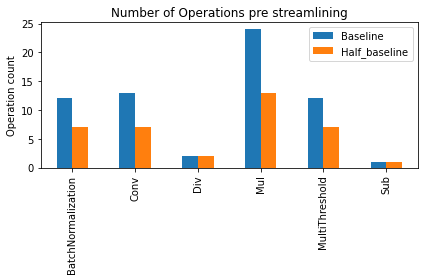

In [37]:
from qonnx.core.modelwrapper import ModelWrapper
import numpy as np

model = ModelWrapper("../verification/partition_0.onnx")
stop_output = model.graph.output[0].name

base_model = ModelWrapper("../../models/mobilenetv1-w4a4_pre_post_tidy.onnx")

ops = []
for n in base_model.graph.node:
    if stop_output != n.output[0]:
        ops.append(n.op_type)
    elif stop_output == n.output[0]:
        ops.append(n.op_type)
        break
ops = np.array(ops)
[op,cnt] = np.unique(ops,return_counts=True)
op_dict = {}
for i,val in enumerate(op):
    op_dict[val]= cnt[i]
with open("../../baseline_build/report/Op_counts_baseline.json", 'r') as f:
    baseline_ops = json.load(f)

df = pd.DataFrame([baseline_ops,op_dict],index=["Baseline", "Half_baseline"],dtype=np.float32)
df.to_csv('../report/Op_counts.csv')
df.T.plot(kind='bar')
plt.ylabel("Operation count")
plt.title("Number of Operations pre streamlining")
plt.tight_layout()
plt.savefig("num_ops.svg")